# バッチ正規化(batch normalizaiton)の効果を確認する
* MNISTデータを用いて、バッチ正規化(batch normalizaiton)の効果を確認する
* 重みwの初期値を決める時の標準偏差を16パターン生成し、それぞれの計算結果を比較する

In [1]:
import numpy as np
import matplotlib.pyplot as plt

try:
    from google.colab import files
    print('Google Colab. 上での実行です')
    print('「ファイルを選択」から、notebook/commonフォルダの中身を全て選択し、アップロードしてください')
    print('===========')
    files.upload()
    !mkdir common
    !mv *.py ./common
except:
    print('ローカル環境での実行です')


from common.multi_layer_net_extend import MultiLayerNetExtend
from common.optimizer import SGD, RMSProp

ローカル環境での実行です


In [2]:
# Load the MNIST dataset
import tensorflow as tf
mnist = tf.keras.datasets.mnist
(X_train, y_train),(X_test, y_test) = mnist.load_data()

from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()

train = X_train/255
test = X_test/255
train = train.reshape(-1, 28*28)
test = test.reshape(-1, 28*28)
train_labels = lb.fit_transform(y_train)
test_labels = lb.fit_transform(y_test)

x_train, t_train = train, train_labels
x_test, t_test = test, test_labels

X_train = train
y_train = train_labels

# 学習データを少なくする
X_train = X_train[:1000]
y_train = y_train[:1000]

2022-09-10 17:23:23.215465: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-10 17:23:24.453856: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-10 17:23:24.454025: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-09-10 17:23:24.554754: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-10 17:23:26.673434: W tensorflow/stream_executor/platform/de

In [3]:
def __train(weight_init_std, ecpochs, batch_size):
    
    # バッチ正規化ありのネットワーク
    bn_network = MultiLayerNetExtend(
                                input_size=784,
                                hidden_size_list=[100, 100, 100, 100, 100],
                                output_size=10, 
                                weight_init_std=weight_init_std,
                                use_batchnorm=True)
    
    # バッチ正規化なしのネットワーク
    network = MultiLayerNetExtend(
                                input_size=784,
                                hidden_size_list=[100, 100, 100, 100, 100],
                                output_size=10,
                                weight_init_std=weight_init_std)
    
    # 最適化手法
#     optimizer = SGD(lr=learning_rate) # 学習初期で発散する場合がある
    optimizer = RMSProp(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    xsize = X_train.shape[0]
    iter_num = np.ceil(xsize / batch_size).astype(np.int)
    
    for epoch in range(epochs):
        print("epoch=%s"%epoch)
            
        # シャッフル
        idx = np.arange(xsize)
        np.random.shuffle(idx)

        for it in range(iter_num):
            """
            ランダムなミニバッチを順番に取り出す
            """
            mask = idx[batch_size*it : batch_size*(it+1)]

            # ミニバッチの生成
            X_batch = X_train[mask]
            y_batch = y_train[mask]

            # パラメータの更新
            for _network in (bn_network,network): 
                grads = _network.gradient(X_batch, y_batch)
                optimizer.update(_network.params, grads)


        # 精度評価
        train_acc = network.accuracy(X_train, y_train)
        bn_train_acc = bn_network.accuracy(X_train, y_train)
        train_acc_list.append(train_acc)
        bn_train_acc_list.append(bn_train_acc)


    return train_acc_list, bn_train_acc_list

## 学習

In [4]:
epochs = 20
batch_size = 100
learning_rate = 0.01

# 重みwの初期値を決める時の標準偏差を16パターン生成する
weight_scale_list = np.logspace(0, -4, num=16, base=10.0) # 常用対数
print("weight_scale_list=", weight_scale_list.round(5))

dic_train_acc_list = {}
dic_bn_train_acc_list = {}

# 学習
for i, w in enumerate(weight_scale_list):
    print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w, epochs, batch_size)
    dic_train_acc_list[i] = train_acc_list
    dic_bn_train_acc_list[i] = bn_train_acc_list 
    

weight_scale_list= [1.0000e+00 5.4117e-01 2.9286e-01 1.5849e-01 8.5770e-02 4.6420e-02
 2.5120e-02 1.3590e-02 7.3600e-03 3.9800e-03 2.1500e-03 1.1700e-03
 6.3000e-04 3.4000e-04 1.8000e-04 1.0000e-04]
============== 1/16 ==============
epoch=0


/tmp/ipykernel_11123/3906880314.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  iter_num = np.ceil(xsize / batch_size).astype(np.int)


epoch=1
epoch=2
epoch=3
epoch=4
epoch=5
epoch=6
epoch=7
epoch=8
epoch=9
epoch=10
epoch=11
epoch=12
epoch=13
epoch=14
epoch=15
epoch=16
epoch=17
epoch=18
epoch=19
============== 2/16 ==============
epoch=0
epoch=1
epoch=2
epoch=3
epoch=4
epoch=5
epoch=6
epoch=7
epoch=8
epoch=9
epoch=10
epoch=11
epoch=12
epoch=13
epoch=14
epoch=15
epoch=16
epoch=17
epoch=18
epoch=19
============== 3/16 ==============
epoch=0
epoch=1
epoch=2
epoch=3
epoch=4
epoch=5
epoch=6
epoch=7
epoch=8
epoch=9
epoch=10
epoch=11
epoch=12
epoch=13
epoch=14
epoch=15
epoch=16
epoch=17
epoch=18
epoch=19
============== 4/16 ==============
epoch=0
epoch=1
epoch=2
epoch=3
epoch=4
epoch=5
epoch=6
epoch=7
epoch=8
epoch=9
epoch=10
epoch=11
epoch=12
epoch=13
epoch=14
epoch=15
epoch=16
epoch=17
epoch=18
epoch=19
============== 5/16 ==============
epoch=0
epoch=1
epoch=2
epoch=3
epoch=4
epoch=5
epoch=6
epoch=7
epoch=8
epoch=9
epoch=10
epoch=11
epoch=12
epoch=13
epoch=14
epoch=15
epoch=16
epoch=17
epoch=18
epoch=19
============== 6/1

## グラフ化

============== 1/16 ==============
============== 2/16 ==============
============== 3/16 ==============
============== 4/16 ==============
============== 5/16 ==============
============== 6/16 ==============
============== 7/16 ==============
============== 8/16 ==============
============== 9/16 ==============
============== 10/16 ==============
============== 11/16 ==============
============== 12/16 ==============
============== 13/16 ==============
============== 14/16 ==============
============== 15/16 ==============
============== 16/16 ==============


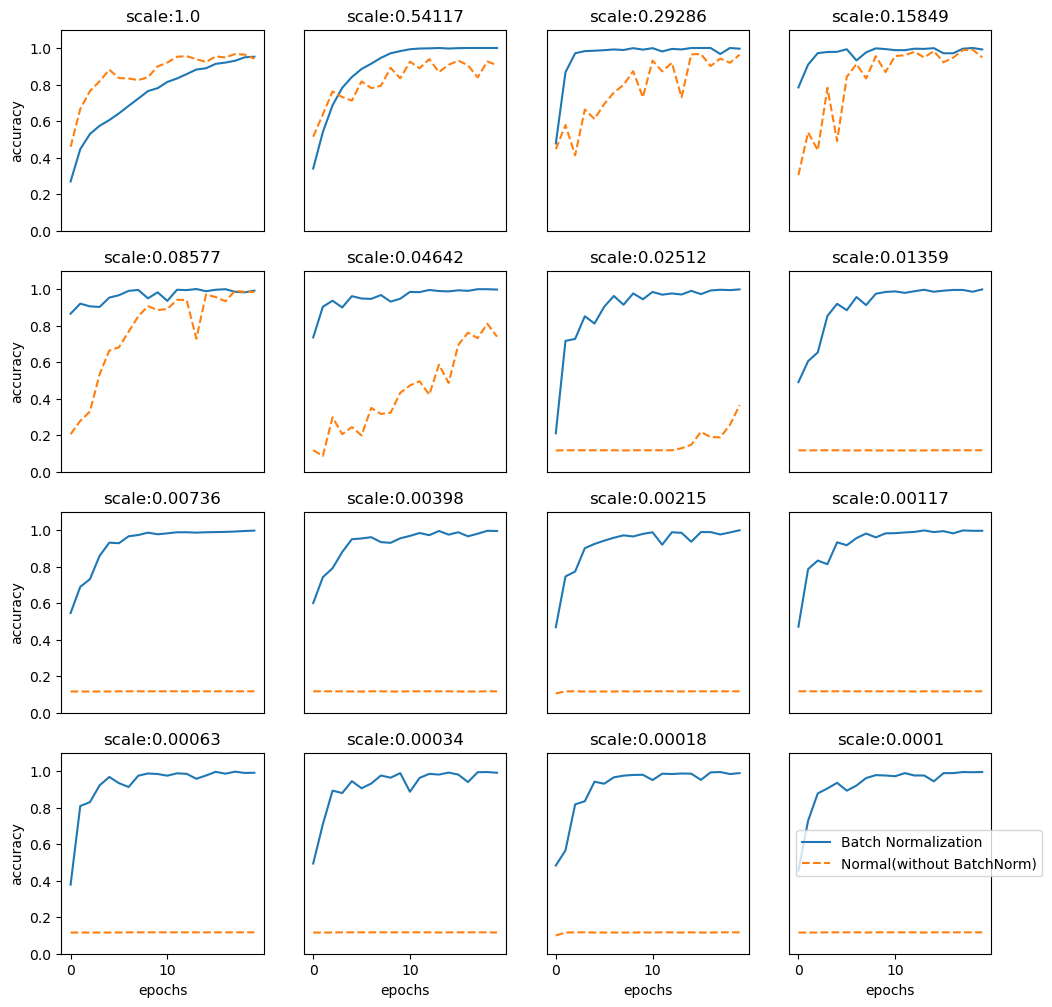

In [5]:
x = np.arange(epochs)
plt.figure(figsize=(12,12))

for i, w in enumerate(weight_scale_list):
    print( "============== " + str(i+1) + "/16" + " ==============")
    
    train_acc_list = dic_train_acc_list[i]
    bn_train_acc_list  = dic_bn_train_acc_list[i]

    plt.subplot(4,4,i+1)
    plt.title("scale:" + str(w.round(5)))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.1)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
        
    if i==15:
        plt.legend(loc='center left')
    
plt.show()

### [演習]
* 上記の16パターンの計算結果を比較し、バッチ正規化の効果を考察しましょう。
* 初期値の標準偏差の影響はどうでしょうか？
* Accuracyが高くなっていく速度(Accuracyが最大になるまでのエポック数)はどうでしょうか？